In [1]:
import json
import numpy as np
import tensorflow as tf

In [2]:
def load_data(path, num_words=None, skip_top=0, seed=113):
    with np.load(path) as f:
        x_train, labels_train = f['x_train'], f['y_train']
        x_test, labels_test = f['x_test'], f['y_test']

    np.random.seed(seed)
    
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train = x_train[indices]
    labels_train = labels_train[indices]
    
    indices = np.arange(len(x_test))
    np.random.shuffle(indices)
    x_test = x_test[indices]
    labels_test = labels_test[indices]
    
    xs = np.concatenate([x_train, x_test])
    labels = np.concatenate([labels_train, labels_test])
    
    if not num_words:
        num_words = max([max(x) for x in xs])

    xs = [[w for w in x if skip_top <= w < num_words] for x in xs]
    
    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
    x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])
    
    return (x_train, y_train), (x_test, y_test)

In [3]:
from functools import partial

# save np.load
np_load_old = partial(np.load)

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(train_data, train_labels), (test_data, test_labels) = load_data('./imdb.npz', num_words=10000)
np.load = np_load_old


C:\Users\Panagiotis\AppData\Local\Temp\ipykernel_8344\886784336.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\Panagiotis\AppData\Local\Temp\ipykernel_8344\886784336.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
def vectorize_sequences(sequences, dimension=10000):
    # creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
#         print(i, sequence)
        results[i, sequence] = 1. # set specific indices of results[i] to be 1s (float)
    return results

train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

print(train_data.shape) # length is same as before
print(train_data[0]) # now, multi-hot encode

# vectorize the labels as well and reshape from (N, ) to (N, 1)
train_labels = np.reshape(np.asarray(train_labels, dtype=np.float32), (len(train_data), 1))
test_labels = np.reshape(np.asarray(test_labels, dtype=np.float32), (len(test_data), 1))

(25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


In [6]:
model = tf.keras.Sequential()

# input shape here is the length of our movie review vector
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(10000, )))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
VAL_SIZE = 10000

val_data = train_data[:VAL_SIZE]
partial_train_data = train_data[VAL_SIZE:]

val_labels = train_labels[:VAL_SIZE]
partial_train_labels = train_labels[VAL_SIZE:]

In [12]:
BATCH_SIZE = 512
SHUFFLE_SIZE = 1000

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
val_set = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

In [9]:
EPOCHS = 10

# store list of metric values for plotting later
training_loss_list = []
training_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(EPOCHS):
    for reviews, labels in training_set:
        # calculate training loss and accuracy
        training_loss, training_accuracy = model.train_on_batch(reviews, labels)
        
    # calculate validation loss and accuracy
    validation_loss, validation_accuracy = model.evaluate(val_data, val_labels)
    
    # add to the lists
    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)
    
    print(('EPOCH %d\t Training Loss: %.2f\t Training Accuracy: %.2f\t Validation Loss: %.2f\t Validation Accuracy: %.2f') % (epoch + 1, training_loss, training_accuracy, validation_loss, validation_accuracy))

313/313 [==============================] - 1s 1ms/step - loss: 0.4328 - binary_accuracy: 0.8524
EPOCH 1	 Training Loss: 0.43	 Training Accuracy: 0.86	 Validation Loss: 0.43	 Validation Accuracy: 0.85
313/313 [==============================] - 0s 1ms/step - loss: 0.3090 - binary_accuracy: 0.8847
EPOCH 2	 Training Loss: 0.28	 Training Accuracy: 0.90	 Validation Loss: 0.31	 Validation Accuracy: 0.88
313/313 [==============================] - 0s 1ms/step - loss: 0.2796 - binary_accuracy: 0.8909
EPOCH 3	 Training Loss: 0.21	 Training Accuracy: 0.92	 Validation Loss: 0.28	 Validation Accuracy: 0.89
313/313 [==============================] - 0s 1ms/step - loss: 0.2800 - binary_accuracy: 0.8900
EPOCH 4	 Training Loss: 0.16	 Training Accuracy: 0.96	 Validation Loss: 0.28	 Validation Accuracy: 0.89
313/313 [==============================] - 0s 1ms/step - loss: 0.2918 - binary_accuracy: 0.8874
EPOCH 5	 Training Loss: 0.11	 Training Accuracy: 0.97	 Validation Loss: 0.29	 Validation Accuracy: 0.89


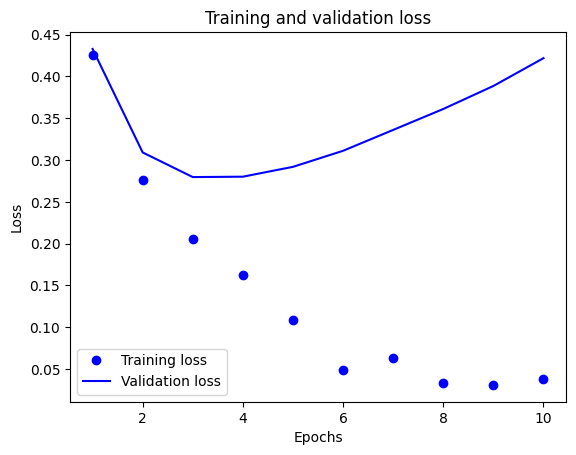

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# "bo" specifies "blue dot"
plt.plot(epochs, training_loss_list, 'bo', label='Training loss')
# b spcifies "solid blue line"
plt.plot(epochs, validation_loss_list, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()